In [ ]:
import numpy as np 
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn as nn # to handle layers
import torch.optim as optim # for optimizer
from collections import namedtuple
from torch.distributions import Categorical
import random
import time 

import matplotlib.pyplot as plt


from google.colab import drive
drive.mount('/content/drive')
import sys

sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks/Basics of Reinforcement Learning/') ## will have to change this path! 

# import premade Gridworlds from Week2 Tutorial
from pyfiles.GridworldEnvs import GridWorld, GridWorld4 #BoundedGridworld, EdgewrapGridworld, CliffWorld

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class fully_connected_AC_network(nn.Module):
    def __init__(self, input_dims, fc1_dims, fc2_dims, output_dims, lr):
        super(fully_connected_AC_network,self).__init__()
        self.input_dims = input_dims
        self.fc1_dims   = fc1_dims
        self.fc2_dims   = fc2_dims
        self.output_dims= output_dims

        self.fc1 = nn.Linear(*self.input_dims,self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.pol = nn.Linear(self.fc2_dims, self.output_dims)
        self.val = nn.Linear(self.fc2_dims, 1)

        self.lr         = lr
        self.optimizer  = optim.Adam(self.parameters(), lr=self.lr)

        self.temperature = 1

        # need loss function?

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self,state):
        state = torch.Tensor(state)
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        value   = self.val(x)
        policy = F.softmax(self.pol(x)/self.temperature,dim=-1)

        return policy, value


### transition cache for storing info about runs 
class Transition_Cache():
    def __init__(self, cache_size):
        self.cache_size = cache_size
        self.transition_cache = []
        self.cache_cntr = 0

    def store_transition(self, transition):
        if len(self.transition_cache) < self.cache_size:
            self.transition_cache.append(transition)
        else:
            self.transition_cache[self.cache_cntr] = transition
            self.cache_cntr += 1 if self.cache_cntr < self.cache_size else 0

    # clear buffer - can be used for MC methods at end of episode
    def clear_cache(self):
        self.transition_cache = []
        self.cache_cntr = 0

    # samples transitions - can be used for TD methods that require buffer
    def sample_transition_cache(self, batch_size):
        # get a list of random index numbers and sample the cache
        sample = random.sample(self.transition_cache, batch_size)

        rewards, expected_values, next_states, terminals  = zip(*[(s.reward, s.expected_value, s.next_state, s.done) for s in sample])

        return rewards, expected_values, next_states, terminals

In [ ]:
Transition = namedtuple('Transition', 'episode, transition, state, action, reward, \
                                next_state, log_prob, expected_value, target_value, done, readable_state')

class Agent(object):
    def __init__(self, network, state_representations=[], **kwargs):
        self.MFC = network
        
        self.transition_cache = Transition_Cache(cache_size=10000)

        self.optimizer = network.optimizer

        self.gamma = kwargs.get('discount',0.98) # discount factor for return computation

        self.get_action = self.MF_action
        self.counter = 0
        self.calc_loss = self.MC_loss

        self.state_reps = state_representations

    def get_state_representation(self,state):
        if self.state_reps == []:
            return state
        else:
            return self.state_reps[state]

    def MF_action(self, state_observation):
        policy, value = self.MFC(state_observation)

        a = Categorical(probs=policy,logits=None)

        action = a.sample()
        
        return action.item(), a.log_prob(action), value.view(-1) ##TODO: why view instead of item

    def MC_loss(self):
        # compute monte carlo return
        self.discount_rwds()

        pol_loss = 0
        val_loss = 0
        for transition in self.transition_cache.transition_cache:
            G_t = transition.target_value
            V_t = transition.expected_value
            delta = G_t - V_t.item()

            log_prob = transition.log_prob
            #print("comput loss for step:", transition.readable_state, log_prob)
            pol_loss += -log_prob * delta
            G_t = torch.Tensor([G_t])
            v_loss = torch.nn.L1Loss()(V_t, G_t)
            val_loss += v_loss
        return pol_loss, val_loss


    def discount_rwds(self):
        transitions = self.transition_cache.transition_cache

        running_add = 0
        returns = []
        for t in reversed(range(len(transitions))):
            running_add = running_add*self.gamma + transitions[t].reward
            transitions[t] = transitions[t]._replace(target_value = running_add)

        self.transition_cache.transition_cache = transitions

    def log_event(self, episode, event, state, action, reward, next_state, log_prob, expected_value, target_value, done, readable_state):
        # episode = trial
        # event = one step in the environment
        transition = Transition(episode=episode,
                                transition=event,
                                state=state,
                                action=action,
                                reward=reward,
                                next_state=next_state,
                                log_prob=log_prob,
                                expected_value=expected_value,
                                target_value=target_value,
                                done=done,
                                readable_state=readable_state
                                )
        self.transition_cache.store_transition(transition)

    def update(self):
        pol_loss, val_loss = self.calc_loss()

        self.optimizer.zero_grad()
        total_loss = pol_loss + val_loss
        total_loss.backward()
        self.optimizer.step()

        return pol_loss, val_loss

    def finish_(self):
        ## if monte carlo, call at end of trial
        ## if TD, call at end of event
        p, v = self.update()
   
        self.transition_cache.clear_cache()
        return p,v

In [ ]:
# make env
env = GridWorld(rows=10, cols=10, rewards={(3,3):10}, step_penalization=0, actionlist = ['Down', 'Up', 'Right', 'Left'], rewarded_action=None)
        


In [ ]:
input_dims = env.nstates
fc1_dims   = 200
fc2_dims   = 200
output_dims = env.action_space.n
network = fully_connected_AC_network(input_dims=[input_dims], fc1_dims=fc1_dims,
                                     fc2_dims=fc2_dims, output_dims=output_dims, lr =0.0005)



oh_state_reps = []
for state in range(env.nstates):
  vec=np.zeros(env.nstates)
  vec[state]=1
  oh_state_reps.append(vec)

ac_agent = Agent(network, state_representations=oh_state_reps)


In [ ]:
index = 10
state = oh_state_reps[index]
action, log_prob, val = ac_agent.get_action(state)
print(action, log_prob, val)

2 tensor(-1.4432, grad_fn=<SqueezeBackward1>) tensor([0.0587], grad_fn=<ViewBackward>)


In [ ]:
class expt(object):
	def __init__(self, agent, environment, **kwargs):
		self.env = environment
		self.agent = agent
		# self.rep_learner = rep_learner  #TODO add in later
		self.data = self.reset_data_logs()
		self.agent.counter = 0

	def reset_data_logs(self):
		data_log = {'total_reward': [],
					'loss': [[], []],
					'trial_length': [],
					'EC_snap': [],
					'P_snap': [],
					'V_snap': []
					}
		return data_log

	def end_of_trial(self, trial):
		p, v = self.agent.finish_()

		self.data['total_reward'].append(self.reward_sum) # removed for bootstrap expts
		self.data['loss'][0].append(p)
		self.data['loss'][1].append(v)

		self.running_rwdavg = np.mean(self.data['total_reward'][-self.print_freq:])

		if trial % self.print_freq == 0:
			print(f"Episode: {trial}, Score: {self.reward_sum} (Running Avg:{self.running_rwdavg}) [{time.time() - self.t}s]")
			self.t = time.time()

	def single_step(self,trial):
		# get representation for given state of env. TODO: should be in agent to get representation?
		state_representation = self.agent.get_state_representation(self.state)
		readable = 0

		# get action from agent
		action, log_prob, expected_value = self.agent.get_action(state_representation)
		# take step in environment
		next_state, reward, done, info = self.env.step(action)

		# end of event
		target_value = 0
		self.reward_sum += reward

		self.agent.log_event(episode=trial, event=self.agent.counter,
							 state=state_representation, action=action, reward=reward, next_state=next_state,
							 log_prob=log_prob, expected_value=expected_value, target_value=target_value,
							 done=done, readable_state=readable)
		self.agent.counter += 1
		self.state = next_state
		return done

	def run(self, NUM_TRIALS, NUM_EVENTS, **kwargs): ### this is the main guy
		self.print_freq = kwargs.get('printfreq', 100)
		self.reset_data_logs()
		self.t = time.time()

		for trial in range(NUM_TRIALS):
			self.state = self.env.reset()
			self.reward_sum = 0

			for event in range(NUM_EVENTS):
				done = self.single_step(trial)

				if done:
					break

			self.end_of_trial(trial)


In [ ]:
ex = expt(ac_agent, env)

In [ ]:
ex.run(1000, 250, printfreq=10)

Episode: 0, Score: 10.0 (Running Avg:10.0) [0.0967099666595459s]
Episode: 10, Score: 10.0 (Running Avg:10.0) [0.8252239227294922s]
Episode: 20, Score: 10.0 (Running Avg:7.0) [1.4991486072540283s]
Episode: 30, Score: 0.0 (Running Avg:4.0) [2.0172371864318848s]
Episode: 40, Score: 10.0 (Running Avg:8.0) [1.3690168857574463s]
Episode: 50, Score: 10.0 (Running Avg:8.0) [1.1636242866516113s]
Episode: 60, Score: 10.0 (Running Avg:6.0) [1.6569738388061523s]
Episode: 70, Score: 0.0 (Running Avg:7.0) [1.7489540576934814s]
Episode: 80, Score: 0.0 (Running Avg:5.0) [1.4230546951293945s]
Episode: 90, Score: 10.0 (Running Avg:10.0) [0.8596746921539307s]
Episode: 100, Score: 10.0 (Running Avg:10.0) [0.8082914352416992s]
Episode: 110, Score: 10.0 (Running Avg:9.0) [1.5746724605560303s]
Episode: 120, Score: 10.0 (Running Avg:8.0) [1.5420253276824951s]
Episode: 130, Score: 10.0 (Running Avg:8.0) [1.12172269821167s]
Episode: 140, Score: 10.0 (Running Avg:10.0) [1.0375919342041016s]
Episode: 150, Score: 

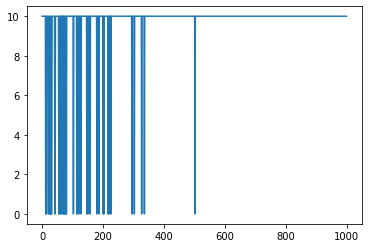

In [ ]:
plt.figure()
plt.plot(ex.data['total_reward'])
plt.show()